# Lasso Regression

# Import the Libraries and Read Data

In [1]:
import numpy as np
import time
import os
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,6]

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
house = pd.read_csv('Sample-Dataset/Maison.csv')
house.head()

,PRIX,SUPERFICIE,CHAMBRES,SDB,ETAGES,ALLEE,SALLEJEU,CAVE,GAZ,AIR,GARAGES,SITUATION
0,42000,5850,3,1,2,1,0,1,0,0,1,0
1,38500,4000,2,1,1,1,0,0,0,0,0,0
2,49500,3060,3,1,1,1,0,0,0,0,0,0
3,60500,6650,3,1,2,1,1,0,0,0,0,0
4,61000,6360,2,1,1,1,0,0,0,0,0,0


# Data Transformation and Analysis

In [3]:
# Rename columns to English
house = house.rename(index = str, columns = {'PRIX': 'price', 'SUPERFICIE': 'area', 'CHAMBRES': 'rooms', 'SDB': 'bathroom',
                                            'ETAGES': 'floors', 'ALLEE': 'driveway', 'SALLEJEU': 'game_room', 'CAVE': 'cellar',
                                            'GAZ': 'gas', 'AIR': 'air', 'GARAGES': 'garage', 'SITUATION': 'situation'})
house.head()

,price,area,rooms,bathroom,floors,driveway,game_room,cellar,gas,air,garage,situation
0,42000,5850,3,1,2,1,0,1,0,0,1,0
1,38500,4000,2,1,1,1,0,0,0,0,0,0
2,49500,3060,3,1,1,1,0,0,0,0,0,0
3,60500,6650,3,1,2,1,1,0,0,0,0,0
4,61000,6360,2,1,1,1,0,0,0,0,0,0


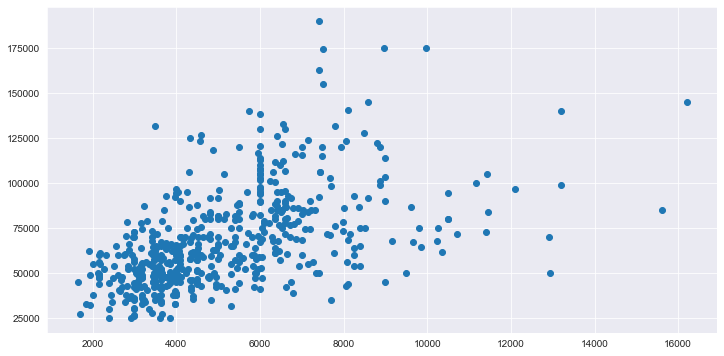

In [4]:
plt.scatter(house['area'], house['price'])
plt.show()

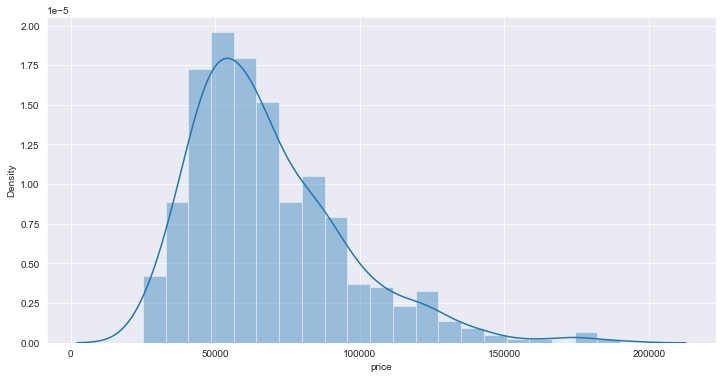

In [5]:
sns.distplot(house['price'])
plt.show()

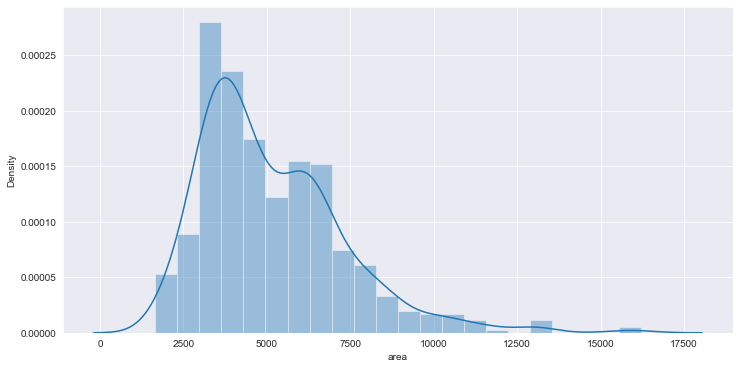

In [6]:
sns.distplot(house['area'])
plt.show()

In [7]:
# Check for Missing Data

total = house.isnull().sum()
percent = (house.isnull().sum()/house.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

# Insight: There is no missing data in any of the columns

,Total,Percent
price,0,0.0
area,0,0.0
rooms,0,0.0
bathroom,0,0.0
floors,0,0.0
driveway,0,0.0
game_room,0,0.0
cellar,0,0.0
gas,0,0.0
air,0,0.0


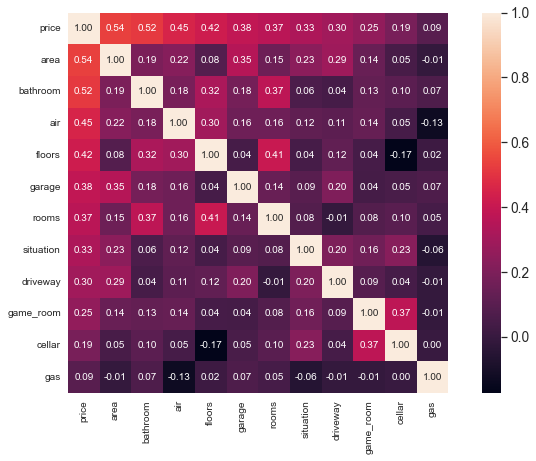

In [8]:
# Create Correlation Matrix
corrmat = house.corr()

# Price correlation matrix
k = 12 # Number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index

# Correlation Matrix
cm = np.corrcoef(house[cols].values.T)
f, ax = plt.subplots(figsize=(12,7))
sns.set(font_scale=1.25)

# Plot the Heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Insight: None of the variables are correlated more than 75%. Hence we can use all the independent variables

In [9]:
y = house['price']
y = list(y)

In [10]:
# Before removing outliers
house.describe()

,price,area,rooms,bathroom,floors,driveway,game_room,cellar,gas,air,garage,situation
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,68121.597070,5150.265568,2.965201,1.285714,1.807692,0.858974,0.177656,0.349817,0.045788,0.316850,0.692308,0.234432
std,26702.670926,2168.158725,0.737388,0.502158,0.868203,0.348367,0.382573,0.477349,0.209216,0.465675,0.861307,0.424032
min,25000.000000,1650.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49125.000000,3600.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62000.000000,4600.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,82000.000000,6360.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,190000.000000,16200.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000


In [11]:
# Code to remove outliers:
# Logic used: Replace values above 95th percentile with 95th percentile value 
# and values below 5th percentile with 5th percentile value

columns = ['price', 'area', 'floors', 'driveway', 'cellar', 'air', 'garage']
for col in columns:
    house[col].loc[house[col] < house[col].quantile(0.05)] = house[col].quantile(0.05)
    house[col].loc[house[col] > house[col].quantile(0.95)] = house[col].quantile(0.95)   

In [12]:
# After removing outliers
house.describe()

,price,area,rooms,bathroom,floors,driveway,game_room,cellar,gas,air,garage,situation
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,67350.086081,5065.584249,2.965201,1.285714,1.807692,0.858974,0.177656,0.349817,0.045788,0.316850,0.670330,0.234432
std,23560.066704,1838.785222,0.737388,0.502158,0.868203,0.348367,0.382573,0.477349,0.209216,0.465675,0.813486,0.424032
min,35000.000000,2565.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49125.000000,3600.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62000.000000,4600.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,82000.000000,6360.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,120000.000000,9000.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000


In [13]:
data = house.iloc[:, 1:].values 

In [14]:
#standardize the data to normal distribution
dataset1_standardized = preprocessing.scale(data)
house1 = pd.DataFrame(dataset1_standardized, columns = ['area', 'rooms', 'bathroom', 'floors', 'driveway', 'game_room', 'cellar', 'gas', 'air', 'garage', 'situation'])
house1.head(5)

,area,rooms,bathroom,floors,driveway,game_room,cellar,gas,air,garage,situation
0,0.426986,0.047235,-0.569495,0.221704,0.40519,-0.464796,1.363319,-0.219054,-0.681034,0.405628,-0.553372
1,-0.580036,-1.310147,-0.569495,-0.931157,0.40519,-0.464796,-0.733504,-0.219054,-0.681034,-0.824776,-0.553372
2,-1.091712,0.047235,-0.569495,-0.931157,0.40519,-0.464796,-0.733504,-0.219054,-0.681034,-0.824776,-0.553372
3,0.862455,0.047235,-0.569495,0.221704,0.40519,2.151480,-0.733504,-0.219054,-0.681034,-0.824776,-0.553372
4,0.704597,-1.310147,-0.569495,-0.931157,0.40519,-0.464796,-0.733504,-0.219054,-0.681034,-0.824776,-0.553372


In [15]:
x = house1[['area', 'rooms', 'bathroom', 'floors', 'driveway', 'game_room', 'cellar', 'gas', 'air', 'garage', 'situation']]

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Lasso Regression

In [17]:
lassoReg = Lasso()

In [18]:
# Hyperparameter Optimization using GridSearchCV

np.random.seed(42)
start = time.time()

param_dist = {'alpha':[0.01, 0.1, 0.5, 1, 10, 50, 100, 200, 250, 275, 300, 310, 325, 350, 375, 380]}

cv_lr = GridSearchCV(lassoReg, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = -1)         # n_jobs should be 1 less than number of CPU cores or -1 to use all available cores

cv_lr.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_lr.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'alpha': 375}
Time taken in grid search:  2.46


In [19]:
lassoReg.set_params(alpha = 375)

Lasso(alpha=375)

In [20]:
lassoReg.fit(x_train,y_train)

Lasso(alpha=375)

In [21]:
y_pred = lassoReg.predict(x_test)
print("Training Score: ", lassoReg.score(x_train,y_train))
print("Testing Score : ", lassoReg.score(x_test,y_test))

Training Score:  0.6811712808925395
Testing Score :  0.6244395582777255


In [22]:
# Create the Final Output Dataframe with Actual and Predicted prices

final_output = x_test
final_output['Actual Price'] = y_test
final_output['Predicted_Price'] = np.round(y_pred, 0)
final_output['Percentage Difference'] = round(((final_output['Predicted_Price'] - final_output['Actual Price'])/final_output['Actual Price'])*100, 1)

In [23]:
x_val = np.arange(len(x_test))
x_val

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109])

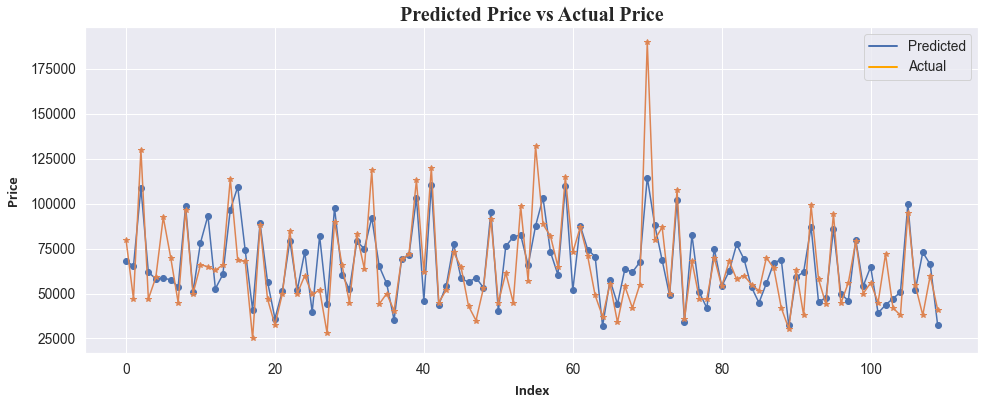

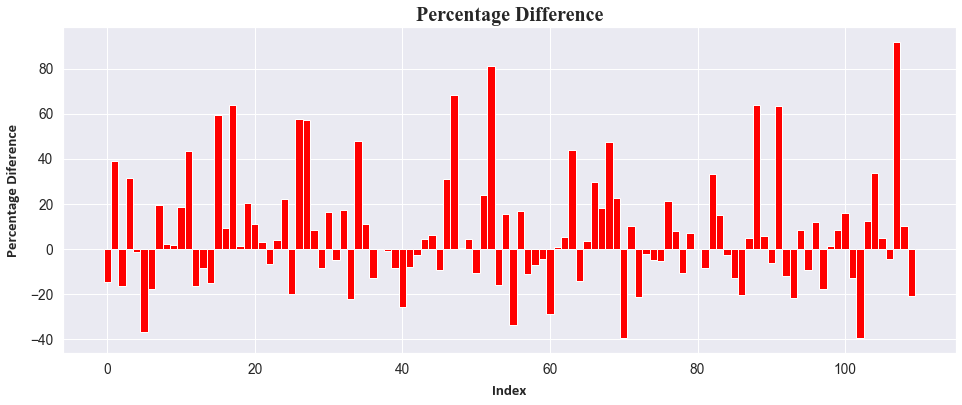

In [24]:
# Graphs to visualize Actual and Predicted Price and their Difference

from matplotlib.lines import Line2D  
fig = plt.figure(figsize = (16,6)) 

plt.plot(x_val, final_output['Predicted_Price'], marker='o')
plt.plot(x_val, final_output['Actual Price'], marker='*')


plt.title("Predicted Price vs Actual Price", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("Price", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')

# Set the Legends                              
legend_elements = [Line2D([0], [0], color='b', lw=2, label="Predicted"), Line2D([0], [0], color='orange', lw=2, label="Actual")]  
plt.legend(handles=legend_elements)

plt.show()

fig = plt.figure(figsize = (16,6))
plt.bar(x_val, final_output['Percentage Difference'], width=1, color = "Red")

plt.title("Percentage Difference", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage Diference", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')
plt.show()

In [25]:
# Save the final output as a CSV File
final_output.to_csv('Sample-Dataset/Lasso_reg_predictions.csv', index = None)
# os.system('Sample-Dataset/Linear_reg_predictions.csv')